## Bayes Factor for Two Different Coin Models
This is taken from chapter 10 of Kruschke's book.  We hypothesize two types of coins.  One type of coin is hypothesized to be tail-biased and the other type of coin is head-biased.  These two possibilities will form our two hypotheses and we will calculate Bayes factors to evaluate their relative credibility.

**Disclaimer**: The models implemented in the notebook are intended for illustrative, teaching purposes only.  Do not use these models for "real" analyses.

In [1]:
import arviz as az
import numpy as np
import pymc as pm

In [2]:
with pm.Model() as eqPrior:
    pm1 = pm.Categorical('pm1', [.5, .5])
    
    omega_0 = .25
    kappa_0 = 12
    theta_0 = pm.Beta('theta_0', mu=.25, sigma=.25)
    
    omega_1 = .75
    kappa_1 = 12
    theta_1 = pm.Beta('theta_1', mu=.75, sigma=.25)
    
    theta = pm.math.switch(pm.math.eq(pm1, 0), theta_0, theta_1)
    
    y2 = pm.Bernoulli('y2', theta, observed=[1,1,0,0,0,0,0,0])

In [3]:
with eqPrior:
    idata1 = pm.sample(10000, tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [pm1]
>NUTS: [theta_0, theta_1]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 38 seconds.
The acceptance probability does not match the target. It is 0.5074, but should be close to 0.8. Try to increase the number of tuning steps.


In [4]:
pm1 = idata1.posterior['pm1'].mean().item()  # mean value of model indicator variable

The posterior is provided by the estimated value of the model indicator variable, `pm1`.

In [5]:
print(f'Posterior: p(model 1|data) = {pm1:.2f}')

Posterior: p(model 1|data) = 0.29


In [6]:
print(f'Posterior: p(model 2|data) = {(1-pm1):.2f}')

Posterior: p(model 2|data) = 0.71


In [7]:
print(f'Posterior odds: p(model 2|data)/p(model 1|data) = {(1-pm1)/pm1:.2f}')

Posterior odds: p(model 2|data)/p(model 1|data) = 2.50


In [8]:
print(f'Bayes factor: p(model 2|data)/p(model 1|data) * p(model 1)/p(model 2) = {(1-pm1)/pm1 * (.5/.5):.2f}')

Bayes factor: p(model 2|data)/p(model 1|data) * p(model 1)/p(model 2) = 2.50


So our posterior odds are identical to our Bayes factor.  This is because our prior on the model indicator variable gave equal credibility to each model.

In [9]:
with pm.Model() as uneqPrior:
    pm1 = pm.Categorical('pm1', [.25, .75])
    
    omega_0 = .25
    kappa_0 = 12
    theta_0 = pm.Beta('theta_0', mu=.25, sigma=.25)
    
    omega_1 = .75
    kappa_1 = 12
    theta_1 = pm.Beta('theta_1', mu=.75, sigma=.25)
    
    theta = pm.math.switch(pm.math.eq(pm1, 0), theta_0, theta_1)
    
    y2 = pm.Bernoulli('y2', theta, observed=[1,1,0,0,0,0,0,0])

In [10]:
with uneqPrior:
    idata2 = pm.sample(10000, tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [pm1]
>NUTS: [theta_0, theta_1]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 43 seconds.


In [11]:
pm1 = idata2.posterior['pm1'].mean().item()  # mean value of model indicator variable

In [12]:
print(f'Posterior: p(model 1|data) = {pm1:.2f}')

Posterior: p(model 1|data) = 0.52


In [13]:
print(f'Posterior: p(model 2|data) = {(1-pm1):.2f}')

Posterior: p(model 2|data) = 0.48


In [14]:
print(f'Posterior odds: p(model 1|data)/p(model 2|data) = {pm1/(1-pm1):.2f}')

Posterior odds: p(model 1|data)/p(model 2|data) = 1.08


In [15]:
print(f'Bayes factor: p(model 1|data)/p(model 2|data) * p(model 2)/p(model 1) = {pm1/(1-pm1) * (.75/.25):.2f}')

Bayes factor: p(model 1|data)/p(model 2|data) * p(model 2)/p(model 1) = 3.25


Here, the posterior odds and the Bayes factor are different because we gave more (prior) credibility to model 2.  So the posterior probabilies of the two model are nearly identical, but that reflects the our priors (favoring model 2) and the likelihoods (favoring model 1) more or less cancelling each other out.

## Bayes Factor with a "Null" Hypothesis
Let's test a more traditional "null hypothesis".  Here, we will posit two types of coins.  One type is characterized by a value of theta that is exactly 0.5.  We have absolute confidence that such a coin's value of theta is not .4999999999 nor .5000000001, etc.  The other type of coin could have any value of theta (0-1) and all values are equally credible a priori.  We then observe some data and ask whether such data should convince us that the coin is "fair" (H_0) or not (H_1).

In [16]:
n_heads = 2
n_tails = 8
data3 = np.repeat([1, 0], [n_heads, n_tails])

In [17]:
with pm.Model() as model3:
    pm1 = pm.Categorical('pm1', [.5, .5])
    
    theta_0 = 0.5
    
    theta_1 = pm.Beta('theta_1', 1, 1)
    
    theta = pm.math.switch(pm.math.eq(pm1, 0), theta_0, theta_1)
    
    y2 = pm.Bernoulli('y2', theta, observed=data3)

In [18]:
with model3:
    idata3 = pm.sample(10000, tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [pm1]
>NUTS: [theta_1]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 32 seconds.


In [19]:
pm1 = idata3.posterior['pm1'].mean().item()  # mean value of model indicator variable

In [20]:
pm1

0.67195

In [21]:
print(f'Posterior: p(model 1|data) = {pm1:.2f}')

Posterior: p(model 1|data) = 0.67


In [22]:
print(f'Posterior: p(model 2|data) = {(1-pm1):.2f}')

Posterior: p(model 2|data) = 0.33


In [23]:
print(f'Bayes factor: p(model 1|data)/p(model 2|data) * p(model 2)/p(model 1) = {pm1/(1-pm1) * (.5/.5):.2f}')

Bayes factor: p(model 1|data)/p(model 2|data) * p(model 2)/p(model 1) = 2.05


So we have no good evidence that would allow us to choose between our 2 hypotheses.  The data isn't particularly consistent with our "null hypothesis".  A priori, the alternative hypothesis entails many credible values of theta that are much more consistent with the observed data (e.g., theta = .2).  However, this alternative hypothesis also entails many values of theta that are **highly** inconsistent with the observed data (e.g., theta = .9999).  So the "null" suffers because there is poor agreement with the data (i.e., likelihood) whereas the alternative hypothesis suffers because it is too agnostic about the possible values of theta.

Let's compare this to a traditional, frequentist procedure to compare these models.  We will first find the most likelihood of theta permitted each model, find the likelihood that each of these values yields, and then take the ratio of these likelihoods.

To get a quick approximation of the maximum likelihood associated with our alternative hypothesis, we can plot the posterior and request a mode from the kernel density estimate.

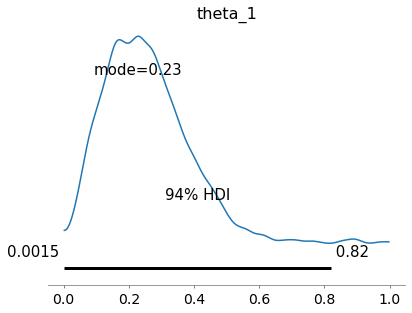

In [24]:
az.plot_posterior(idata3, var_names=['theta_1'], point_estimate='mode');

So the value of theta that gives us the maximum likelihood is 0.2 (which makes sense because we observed 2 heads in our 10 flips).  So we can use that.  Of course our null hypothesis has theta fixed at 0.5.

In [25]:
mle_h0 = .5
mle_h1 = .2 # 20% of flips were heads

These are the values of theta that maximize the likelihood of the observed data.  Now we need to know what the likelihood of our observed data under each of these values of theta.  We know how to calculate the likelihood of a set of flips from earlier.

In [26]:
def likelihood(theta, n_flips, n_heads):
    return (theta**n_heads) * ( (1-theta)**(n_flips - n_heads) )

In [27]:
likelihood_h0 = likelihood(mle_h0, n_heads+n_tails, n_heads)
print(f'likelihood_h0 = {likelihood_h0:.4f}')
likelihood_h1 = likelihood(mle_h1, n_heads+n_tails, n_heads)
print(f'likelihood_h1 = {likelihood_h1:.4f}')

likelihood_h0 = 0.0010
likelihood_h1 = 0.0067


In [28]:
print(f'Likelihood Ratio = {likelihood_h1 / likelihood_h0:.2f}')

Likelihood Ratio = 6.87


In the limit of large data, likelihood ratios (multiplied by 2) are chi-squared distributed, with a degree of freedom equal to the difference in the number of parameters in the two models.  Here, our alternative hypothesis has 1 parameter (theta) and our null hypothesis doesn't have any.  So the df=1.  Let's calculate a p-value.

In [29]:
from scipy.stats import chi2

print(f'p = {1 - chi2.cdf(2 * (likelihood_h1 / likelihood_h0), 1):.4f}')

p = 0.0002


So our likelihood-ratio test is suggesting that we should be extremely skeptical of our null hypothesis whereas the Bayes factor was basically ambivalent.  What is going on?

The key difference between the Bayes factor and the likelihood-ratio test is that the Bayes factor treats our alternative hypothesis as embodying the full prior (i.e., theta~U(0,1)), whereas the likelihood ratio test, being a frequestist test, doesn't know anything about our priors.  As a result, the likelihood-ratio test permits the alternative hypothesis to reflect whatever value of theta is most consistent with the observed data (i.e., the maximium likelihood estimate).  But that's an extrodinary degree of flexibility.  Our alternative hypothesis gets to adapt itself to the data it is seeking to explain, no matter how credible the final estimate was before we observed the data.  This means that we should construct our hypotheses so as to be as open-minded and agnostic as possible, because we are only penalized when we observe data that are inconsistent with any configuration of our hypothesis (e.g., combination of parameter values).  We are penalized for being unparsimonious, but only coarsely (i.e., the alternative hypothesis is penalized for having 1 more parameter than our "null").

In the Bayes factor, our agnosticism about the cedible values of theta represents a substantial tradeoff.  Being uncertain is good because an uncertain hypothesis will be somewhat consistent with many different patterns of data that **might** be observed.  However, an uncertain hypotheiss will also be consistent with many different patterns of data that **were not** observed.  The former is good, but the latter is bad.  The Bayes factor (and all Bayesian approaches) appropriately balance both of these facets and does so thoroughly (incorporating the prior credibility of each parameter value and how the likleihood of the data in light of each parameter value).  This is the sense in which people say that Bayesian approaches naturally ensure parsimony.  The more agnostic you are (regardless of how many parameters your model has), the less parsimonious your hypotheses are, and the lower the likelihood of the overall model will be.

To see this in action, let's consider the same 2 hypothesis but evaluate them on a data set that is highly likely under the "null".  In this data set, 50% of flips come up heads.  In a frequentist context, our two hypotheses are indistinguisable.  In a Bayesian context, the parsimony of the "null" should cause it to win out over the more agnostic alterntive hypothesis.

In [30]:
n_heads = 10
n_tails = 10
data3 = np.repeat([1, 0], [n_heads, n_tails])

In [31]:
with pm.Model() as model4:
    pm1 = pm.Categorical('pm1', [.5, .5])
    
    theta_0 = 0.5
    
    theta_1 = pm.Beta('theta_1', 1, 1)
    
    theta = pm.math.switch(pm.math.eq(pm1, 0), theta_0, theta_1)
    
    y2 = pm.Bernoulli('y2', theta, observed=data3)

In [32]:
with model4:
    idata4 = pm.sample(10000, tune=10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [pm1]
>NUTS: [theta_1]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 32 seconds.


In [33]:
pm1 = idata4.posterior['pm1'].mean().item()  # mean value of model indicator variable

In [34]:
print(f'Posterior: p(model 1|data) = {pm1:.2f}')

Posterior: p(model 1|data) = 0.21


In [35]:
print(f'Posterior: p(model 2|data) = {(1-pm1):.2f}')

Posterior: p(model 2|data) = 0.79


In [36]:
print(f'Bayes factor: p(model 2|data)/p(model 1|data) * p(model 1)/p(model 2) = {(1-pm1)/pm1 * (.5/.5):.2f}')

Bayes factor: p(model 2|data)/p(model 1|data) * p(model 1)/p(model 2) = 3.65


Using our t-shirt guide to interpreting Bayes factor, we have "substantial evidence" in favor of our "null" hypothesis.  Why?  Because our alternative hypothesis was agnostic and implied that many theta values were credible.  The "null", in contrast, committed to exactly 1.  So our null hypothesis is far more parsimonious than the alternative.

What does the likelihood-ratio test have to say about this?

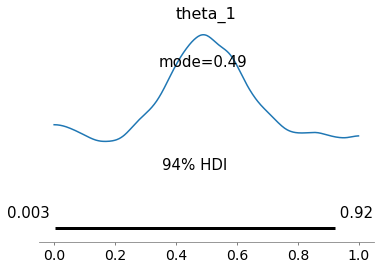

In [37]:
az.plot_posterior(idata4, var_names=['theta_1'], point_estimate='mode');

In [38]:
mle_h0 = .5
mle_h1 = .5 # 50% of flips were heads

In [39]:
likelihood_h0 = likelihood(mle_h0, n_heads+n_tails, n_heads)
print(f'likelihood_h0 = {likelihood_h0:.8f}')
likelihood_h1 = likelihood(mle_h1, n_heads+n_tails, n_heads)
print(f'likelihood_h1 = {likelihood_h1:.8f}')

likelihood_h0 = 0.00000095
likelihood_h1 = 0.00000095


In [40]:
print(f'Likelihood Ratio = {likelihood_h1 / likelihood_h0:.2f}')

Likelihood Ratio = 1.00


In [41]:
print(f'p = {1 - chi2.cdf(-2 * (likelihood_h1 / likelihood_h0), 1):.4f}')

p = 1.0000


The result of this likelihood-ratio test is pretty trivial, but confirms the expectation described above.  By treating each hypothesis as synomymous with the corresponding maximum likelihood estimate of theta, the two hypotheses end up being identical when we observe heads on 50% of our flips.

### Take home message
Bayes factors are fine, but I would almost never recommend them.  They are useful for performing NHST-style "tests" in a Bayesian framework, but the idea that you have to **choose** between two or more hypotheses is something that (I think) researchers never should have been doing in the first place.

This is particularly true in the case of these point-estimate, "null"-style models.  We either believe that the value of $\theta$ is *exactly* 0.50000000 or whether have no clue whatsoever what the value of $\theta$ is?  It seems plausible that we don't actually believe one of these (e.g., as is the case in most NHST settings).

On top of that, Bayes factors do not reflect our prior beliefs about the credibility of the models we are comparing.  Bayes factors speak to the "evidential value" of our data.  But, as we saw above, the data can strongly imply one model and our priors can strongly favor the other.  In such cases, Bayes factors only provide part of the relevant story.

What do I recommend?  If you have data and a model and you would like to answer questions about the values of model parameters in light of the data, then **estimate** the credible values of those parameters and use the posterior to answer your questions.  If you are not sure whether a coin is fair or not, build a model in which theta can take on many values of theta and ask how credible the values far from 0.5 are (for one or more definitions of "far").  Ask how credible values of theta close to 0.5 are (for one or more definitions of "close").  But dichotomizing the world seems unwise.  Also the sampler doesn't like it.